# Can We Go Faster?

## This notebook demonstrates relative speed differences between single-threaded and parallel programming approaches for different operations. Approaches compared are numpy.where() vs. dask.array.where(), and more complex operations.

### Set up the tests

In [ ]:
from dask.distributed import Client

client = Client(n_workers=6, threads_per_worker=1, memory_limit='14GB')
client

import numpy as np
import dask.array as da

Create an array of 100 million 1's and 0's

In [2]:
largedata = np.random.randint(0,2,100000000)
np.unique(largedata)

array([0, 1])

Create a similar array using Dask

In [3]:
distdata = da.random.randint(0,2,100000000)

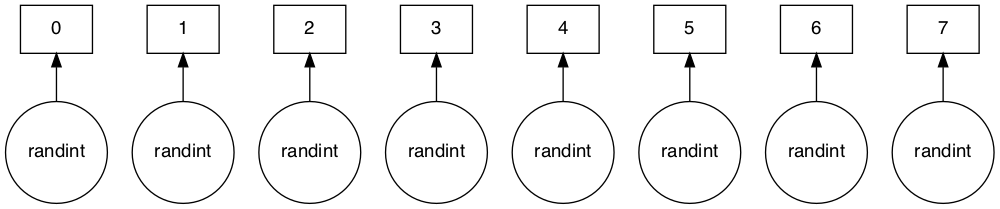

In [4]:
distdata.visualize()

In [5]:
distdata

dask.array<randint, shape=(100000000,), dtype=int64, chunksize=(12500000,), chunktype=numpy.ndarray>

Lazy operation, so you may not see data here depending on whether distdata has been created yet or not.

In [6]:
type(distdata)

dask.array.core.Array

## numpy.where vs. dask.array.where - single operation test

Use NumPy function (np.where) to change all 0's to -1's on largedata and time it.

In [7]:
%time np.where(largedata < 1, -1, 1)

CPU times: user 165 ms, sys: 172 ms, total: 336 ms
Wall time: 313 ms


array([-1, -1,  1, ...,  1, -1, -1])

* On my laptop, this usually averaged around 300 milliseconds

### Take a look at how Dask will approach this problem - see the parallelized approach logic, then run it

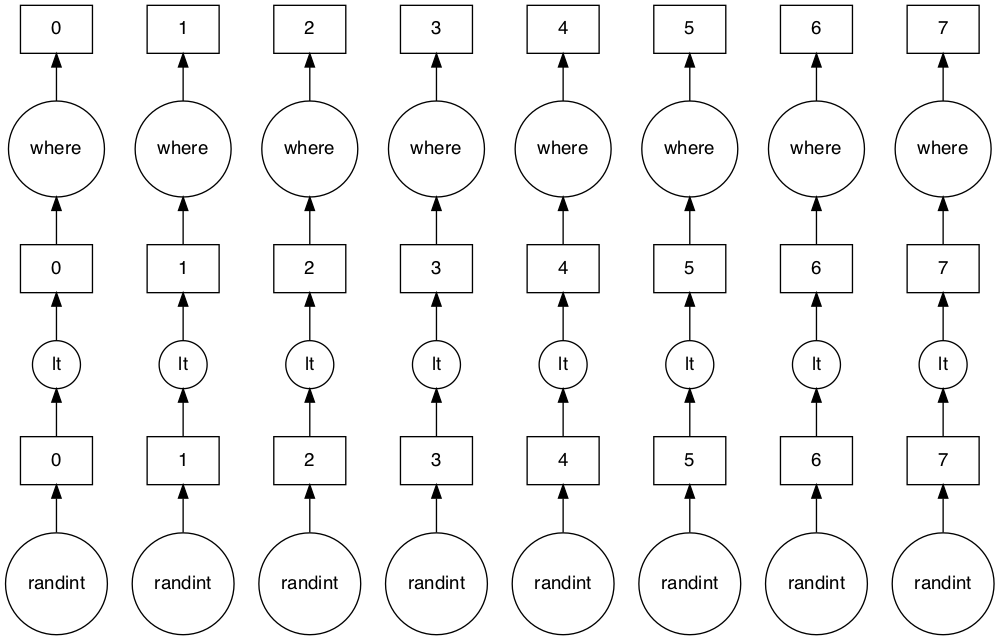

In [8]:
da.where(distdata<1, 1, 1).visualize()

In [9]:
%time da.where(distdata<1, 1, 1).compute()

CPU times: user 491 ms, sys: 944 ms, total: 1.44 s
Wall time: 1.91 s


array([1, 1, 1, ..., 1, 1, 1])

* Wall time on my computer was 1.9 seconds, or more than 6x slower than native NumPy.

Not apples to apples because the array is being generated and evaluated as well. Need to make both of these tests a function to run the whole thing in one command for equivalent timing.

In [13]:
def numpytest():
    largedata = np.random.randint(0,2,100000000)
    np.where(largedata < 1, -1, 1)
    print("numpytest done")

In [14]:
%time numpytest()

numpytest done
CPU times: user 652 ms, sys: 386 ms, total: 1.04 s
Wall time: 1.06 s


* Wall time on my computer was 1.06 seconds

In [15]:
def dasktest():
    distdata = da.random.randint(0,2,100000000)
    da.where(distdata<1, 1, 1).compute()
    print("dasktest done")

In [16]:
%time dasktest()

dasktest done
CPU times: user 408 ms, sys: 1.02 s, total: 1.43 s
Wall time: 1.71 s


* Wall time on my computer was 1.71 seconds - or about 50% more time than native NumPy

## On a 100 million object basis, the overhead involved in parallel operations is more than the speed gained by doing so. Go bigger (add a zero)?

In [17]:
def numpytest2():
    largedata = np.random.randint(0,2,1000000000)
    np.where(largedata < 1, -1, 1)
    print("numpytest2 done")

In [18]:
%time numpytest2()

numpytest done
CPU times: user 6.63 s, sys: 5.28 s, total: 11.9 s
Wall time: 14.4 s


* Wall time 14.4 seconds

In [19]:
def dasktest2():
    distdata = da.random.randint(0,2,1000000000)
    da.where(distdata<1, 1, 1).compute()
    print("dasktest2 done")

In [20]:
%time dasktest2()

dasktest2 done
CPU times: user 5 s, sys: 16.8 s, total: 21.8 s
Wall time: 31.5 s


* Wall time 31.5 seconds, about 2x longer than native NumPy

## So a simple where function / replace seems to take a hit for the parallelization. What happens if I make the problem more complex?

### Does array shape make a difference?

In [4]:
def numpytest3():
    largedata = np.random.randint(2,size = (40000,40000))
    np.where(largedata < 1, -1, 1)
    print("numpytest3 done")

In [5]:
%time numpytest3()

numpytest3 done
CPU times: user 10.7 s, sys: 8.32 s, total: 19.1 s
Wall time: 23.1 s


* Wall time 23.1 seconds

In [6]:
def dasktest3():
    distdata = da.random.randint(2,size = (40000,40000))
    da.where(distdata<1, 1, 1).compute()
    print("dasktest3 done")

In [7]:
%time dasktest3()

dasktest3 done
CPU times: user 8.47 s, sys: 27.9 s, total: 36.4 s
Wall time: 53.4 s


* Wall time 53.4 seconds, or 2.5 times longer

### Array shape didn't seem to change the outcome. What if the computations are more complex?

In [41]:
def numpytest4():
    largedata = np.random.rand(40000, 40000)
    result = np.sum(np.square(largedata/2))
    print("result {}".format(result))
    print("numpytest4 done")

In [42]:
%time numpytest4()

result 133332580.25091831
numpytest4 done
CPU times: user 20 s, sys: 31.3 s, total: 51.3 s
Wall time: 3min 59s


* Wall time on my computer was about 4 minutes

In [39]:
def dasktest4():
    distdata = da.random.random(size=(40000,40000))
    result = da.sum(da.square(distdata/2))
    result.compute()
    print("result {}".format(result.compute()))
    print("dasktest4 done")

In [40]:
%time dasktest4()

result 133330310.42371261
dasktest4 done
CPU times: user 1.43 s, sys: 166 ms, total: 1.6 s
Wall time: 5.82 s


* Wall time was less than 6 seconds

## Wait, what?

## On a more complex problem, parallelization via Dask produced a result in under 3% of the time it took on native NumPy (I ran this  a bunch of times and added the print statements to make sure the results were coming out equivalent just to be sure. It's legit.)

## In other words, for this problem, Dask produced a performance improvement of 97%, from 4 minutes to 6 seconds to solve the same problem.

## Taking a look at the magic behind the scenes that makes this possible:

In [23]:
distdata = da.random.random(size=(40000,40000))

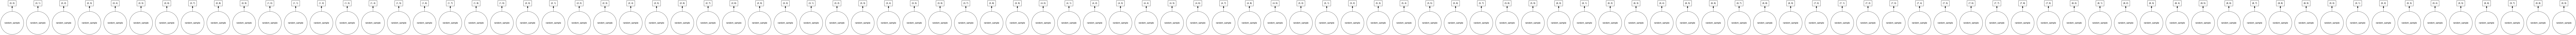

In [24]:
distdata.visualize()

In [25]:
da.sum(da.square(distdata/2)).visualize()